# Anomaly detection in financial data
## 1. Preprocessing Steps
### Data Visualization and Initial Preprocessing

In [ ]:
import yfinance as yf 
import pandas as pd 

assets = ['JPM', 'GS', 'MS', 'BLK', 'C'] 
start_date = '2018-01-01' 
end_date = '2023-11-30' 
stocks = yf.download(assets, start=start_date, end=end_date)['Adj Close']

# Convert the Date column to datetime format
stocks['Date'] = pd.to_datetime(stocks['Date'])

# Set the Date column as the index
stocks.set_index('Date', inplace=True)

# Display the first few rows of the DataFrame
stocks.head()

,BLK,C,GS,JPM,MS
Date,,,,,
2018-01-02,429.839417,59.538162,221.021774,89.109085,42.931217
2018-01-03,434.374573,59.722324,218.964294,89.199875,43.046375
2018-01-04,440.108826,60.458935,222.024582,90.477730,43.704460
2018-01-05,443.858612,60.378891,220.892120,89.896881,43.688011
2018-01-08,447.169189,59.674274,217.684845,90.029648,43.507042


In [5]:
# Descriptive Analysis of Stock Price Data
stocks.describe().round(1)

,BLK,C,GS,JPM,MS
count,1488.0,1488.0,1488.0,1488.0,1488.0
mean,567.8,52.1,256.4,114.1,61.0
std,152.8,8.7,72.2,22.9,21.6
min,294.3,30.0,121.5,69.3,24.2
25%,429.8,44.4,188.6,93.0,40.6
50%,571.5,53.0,233.6,110.7,57.3
75%,677.8,58.9,321.0,136.4,81.4
max,902.3,71.0,393.0,158.9,99.9


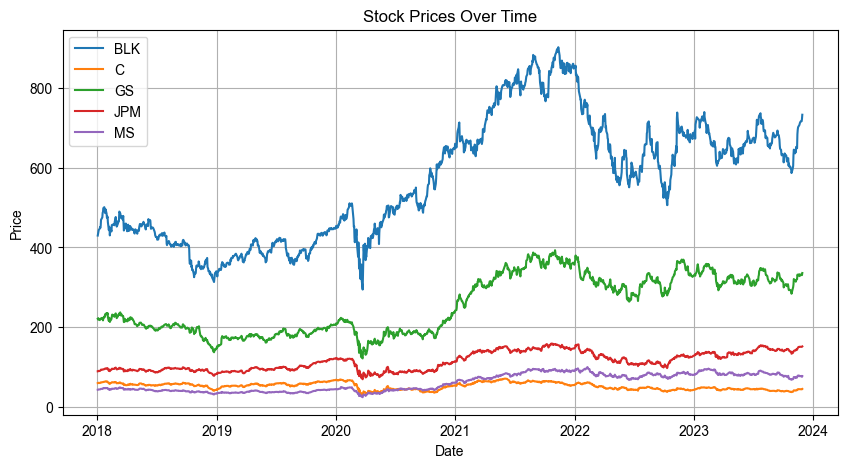

In [3]:

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Function to plot stock prices
def plot_time_series(data, title="Stock Prices Over Time"):
    plt.figure(figsize=(10,5))
    for column in data.columns:
        plt.plot(data.index, data[column], label=column)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.savefig('Figs/stock price over time.jpg', dpi=300, bbox_inches='tight')
    plt.show()

# Plot the time series data
plot_time_series(stocks, title="Stock Prices Over Time")

We can compute the percentage of changes in the daily closing price of each stock as follows:

\begin{equation}
\delta_i = 100 \times \frac{x_i - x_{i-1}}{x_{i-1}} 
\end{equation}

where  $x_i$  denotes the price of a stock on day $i$ and $x_{i-1}$ denotes the price on its previous day,$i-1$.

In [4]:
import numpy as np
np.random.seed(42)

N,d = stocks.shape
delta_ns = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values-stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values),
                    columns=stocks.columns, index=stocks.iloc[1:].index)
delta_ns = delta_ns.ffill()
delta_ns.head()

,BLK,C,GS,JPM,MS
Date,,,,,
2018-01-03,1.055082,0.309318,-0.930895,0.101886,0.268239
2018-01-04,1.320117,1.233392,1.397619,1.432575,1.528781
2018-01-05,0.852013,-0.132394,-0.510061,-0.641980,-0.037637
2018-01-08,0.745863,-1.166992,-1.451965,0.147688,-0.414231
2018-01-09,0.840438,1.046553,0.845902,0.506933,0.775188


In [5]:
from sklearn.preprocessing import StandardScaler

# Get dimensions of delta_ns (_ns stands for not standardized)
N, d = delta_ns.shape

# Standardize the data
scaler = StandardScaler()
delta_standardized_values = scaler.fit_transform(delta_ns)

# Create a new DataFrame with the same index and columns as the original delta
delta = pd.DataFrame(delta_standardized_values, index=delta_ns.index, columns=delta_ns.columns)

# Display the resulting DataFrame
delta.head()

,BLK,C,GS,JPM,MS
Date,,,,,
2018-01-03,0.510370,0.129088,-0.488670,0.024604,0.095517
2018-01-04,0.645635,0.525409,0.673503,0.713576,0.680612
2018-01-05,0.406730,-0.060355,-0.278630,-0.360537,-0.046459
2018-01-08,0.352555,-0.504077,-0.748738,0.048318,-0.221260
2018-01-09,0.400822,0.445277,0.398138,0.234319,0.330823


In [6]:
# Compute the correlation matrix and find the relationships i stock prices
correlation_matrix = delta.corr()

# Display the correlation matrix
correlation_matrix

,BLK,C,GS,JPM,MS
BLK,1.000000,0.664580,0.686719,0.691056,0.722920
C,0.664580,1.000000,0.823280,0.869111,0.824168
GS,0.686719,0.823280,1.000000,0.828263,0.870732
JPM,0.691056,0.869111,0.828263,1.000000,0.834985
MS,0.722920,0.824168,0.870732,0.834985,1.000000


## 2. Visual Inspection
## Checking if data in a DataFrame follows a multivariate Gaussian distribution can be complex. Data visualizations can help assess this. 
### 2.1 Pair Plot
 The scatter plots and histograms should show a roughly elliptical shape for bivariate normality.

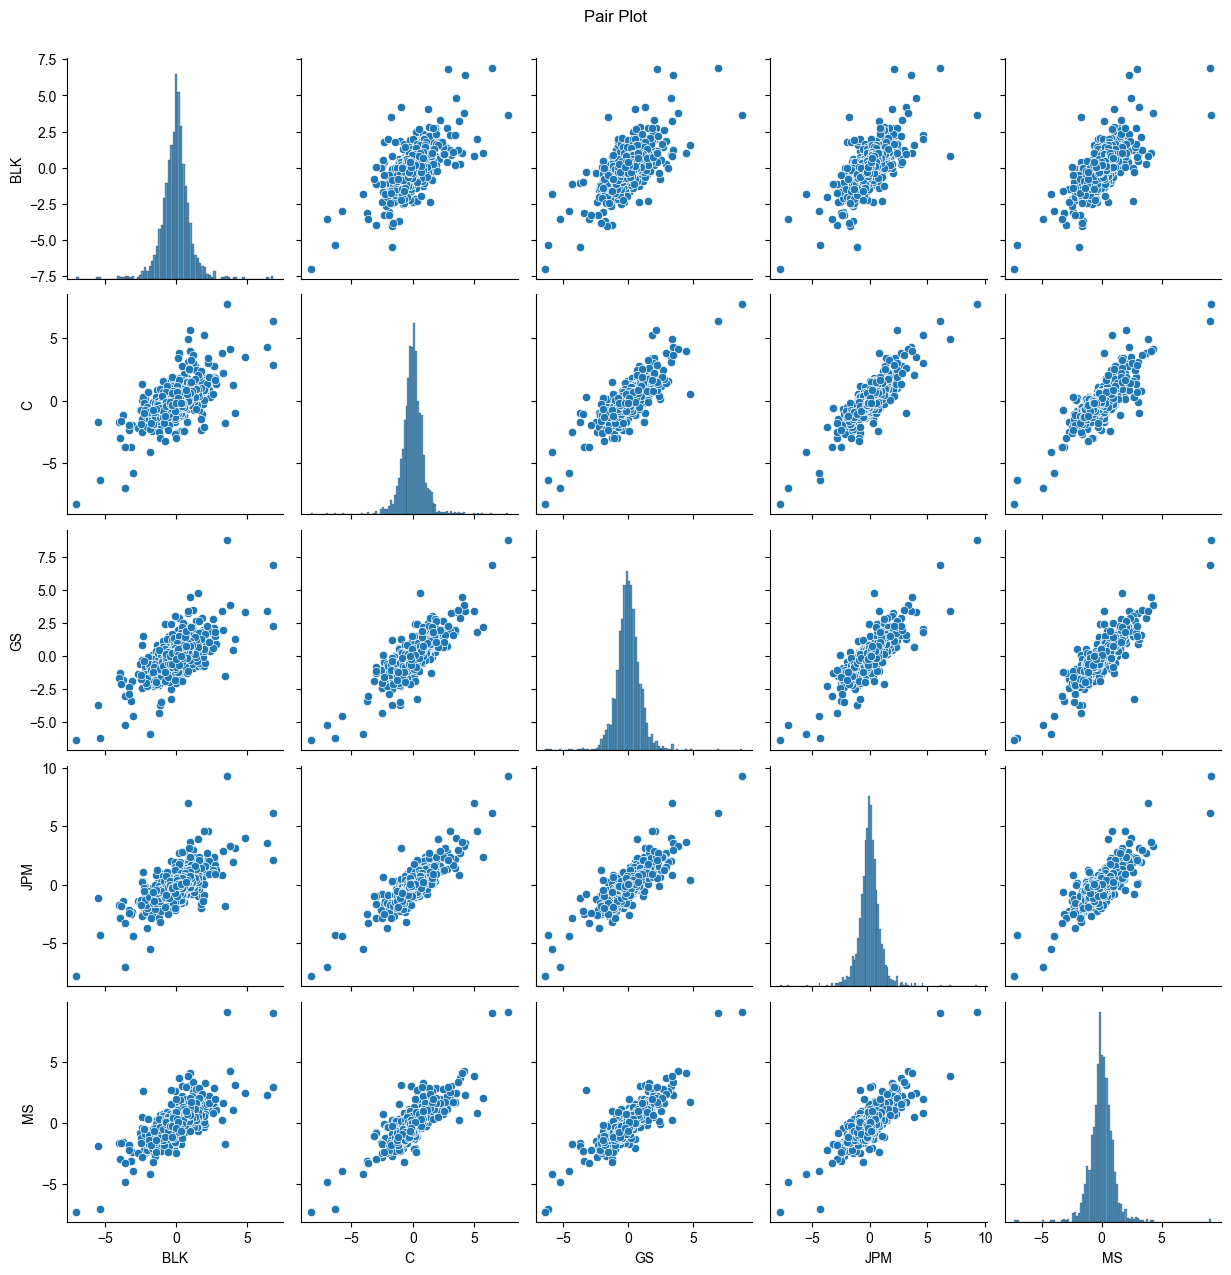

In [7]:
import seaborn as sns

sns.pairplot(delta)
plt.suptitle('Pair Plot', y=1.02)
plt.savefig('Figs/pair plot.jpg', dpi=300, bbox_inches='tight')
plt.show()


### 2.2 Q-Q Plot: 
Points should fall on a straight line for Normal distributions.

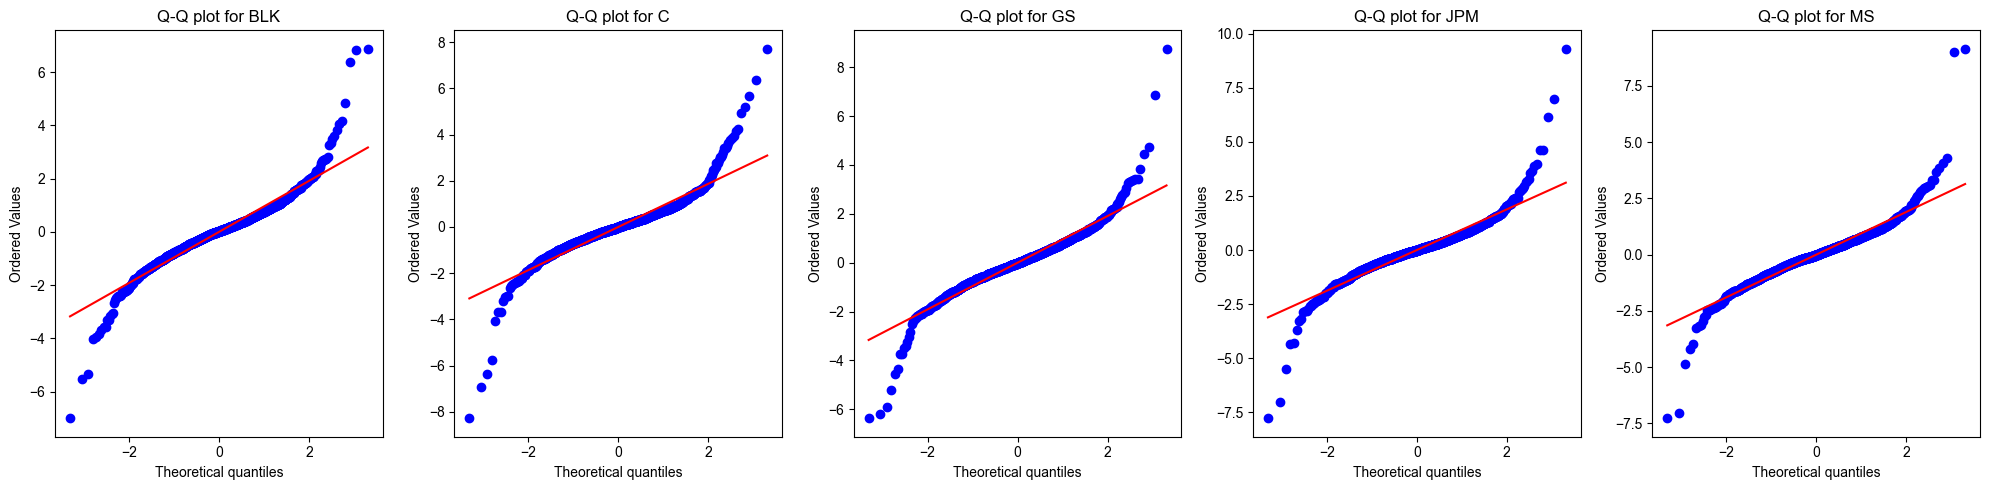

In [8]:
import scipy.stats as stats

# Number of columns in delta
num_columns = len(delta.columns)

# Create a 1x5 grid for subplots
fig, axs = plt.subplots(1, num_columns, figsize=(20, 5))

# Q-Q plot for each column
for i, column in enumerate(delta.columns):
    stats.probplot(delta[column], dist="norm", plot=axs[i])
    axs[i].set_title(f'Q-Q plot for {column}')

# Adjust layout
plt.tight_layout()
plt.savefig('Figs/qq plot.jpg', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# Skewness and Kurtosis for each column
for column in delta.columns:
    skew = delta[column].skew()
    kurtosis = delta[column].kurtosis()
    print(f'{column} skewness: {skew}, kurtosis: {kurtosis}')

BLK skewness: 0.16207482742884413, kurtosis: 8.048017672375314
C skewness: 0.06489036013918956, kurtosis: 12.295330320029052
GS skewness: 0.19182672190601605, kurtosis: 9.861177519197371
JPM skewness: 0.37862965560901124, kurtosis: 13.277020938776005
MS skewness: 0.5435995904316695, kurtosis: 13.495197575820022


### Conclusion on Preprocessing the Data

- **BLK:** Nearly symmetric distribution with very heavy tails.
- **C:** Nearly symmetric distribution with extremely heavy tails.
- **GS:** Slightly right-skewed distribution with very heavy tails.
- **JPM:** Noticeably right-skewed distribution with extremely heavy tails.
- **MS:** More pronounced right-skewed distribution with extremely heavy tails.

These results indicate that while the distributions are somewhat symmetric, they exhibit heavy tails and sharp peaks, implying a higher likelihood of extreme values compared to a normal distribution.


## 3. Anomaly Detection Algorithms
### 3.1 IQR Method

In [10]:
# Function to show the anomalies in price data
def plot_anomalies(data, anomaly_indices ,title , save_loc):
    plt.figure(figsize=(10, 5))
    for column in data.columns:
        plt.plot(data.index, data[column], label=column)
        for idx in anomaly_indices:
            plt.axvline(x=idx, color='red', linestyle='--', linewidth=0.1)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_loc, dpi=300, bbox_inches='tight')
    plt.show()

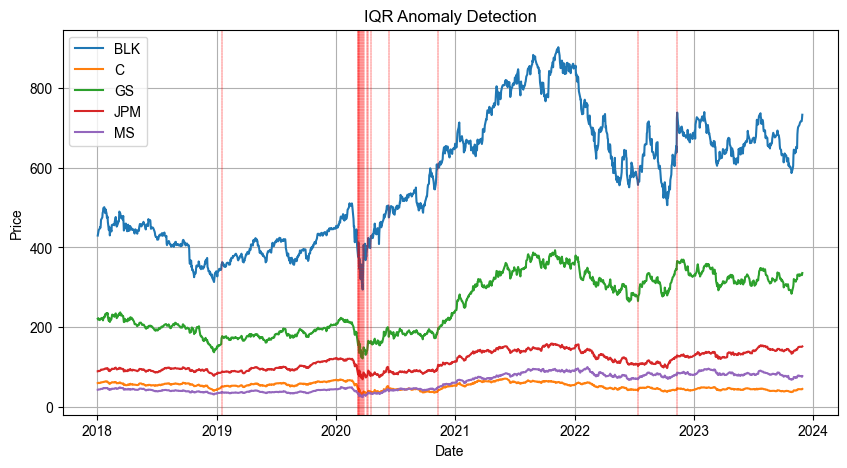

,BLK,C,GS,JPM,MS
Date,,,,,
2019-01-16,357.6,50.9,172.7,87.3,37.4
2020-03-09,376.7,43.5,155.5,81.9,32.7
2020-03-10,412.6,47.1,165.9,88.2,34.4
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-20,318.9,32.2,124.6,73.2,25.8
2020-03-24,334.2,34.4,138.2,77.5,28.9


In [11]:
# Calculate IQR and detect anomalies
def detect_anomalies_iqr(data):
    anomalies = pd.DataFrame(index=data.index)
    for column in data.columns:
        if column != 'Date':
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 4 * IQR
            upper_bound = Q3 + 4 * IQR
            anomalies[column] = (data[column] < lower_bound) | (data[column] > upper_bound)
    return anomalies

# Apply IQR method to each column in delta matrix
anomalies = detect_anomalies_iqr(delta[['BLK', 'C', 'GS', 'JPM', 'MS']])

# Add anomaly column to delta DataFrame
delta_iqr = delta.copy()
delta_iqr['Anomaly'] = anomalies.any(axis=1)

iqr_result_indx = delta_iqr.loc[delta_iqr['Anomaly']==True].index



# Plot anomalies detected by IQR method
plot_anomalies(stocks, iqr_result_indx, title="IQR Anomaly Detection" , save_loc = 'Figs/iqr anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(iqr_result_indx)].round(1)


### 3.2 Rolling Statistics

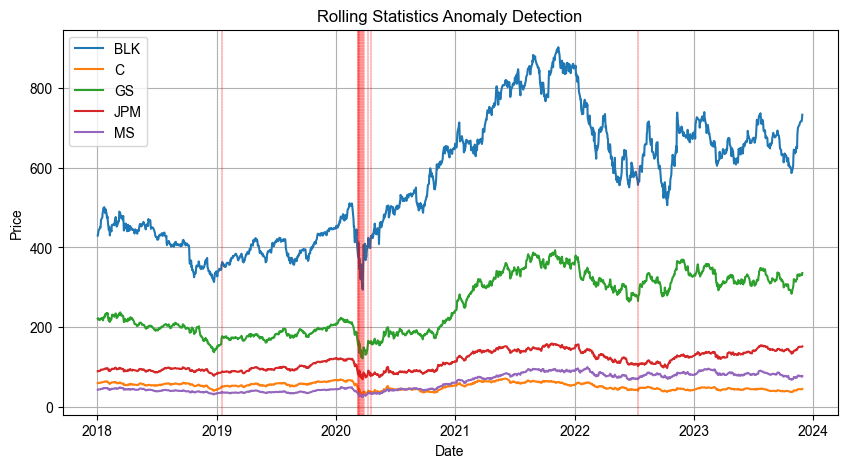

,BLK,C,GS,JPM,MS
Date,,,,,
2019-01-16,357.6,50.9,172.7,87.3,37.4
2020-03-09,376.7,43.5,155.5,81.9,32.7
2020-03-10,412.6,47.1,165.9,88.2,34.4
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-20,318.9,32.2,124.6,73.2,25.8
2020-03-24,334.2,34.4,138.2,77.5,28.9


In [12]:
# Set rolling window size and modified Z-score threshold
window_size = 200
modified_z_score_threshold = 7  

# Function to detect anomalies using rolling median and MAD
def detect_anomalies_rolling_median_mad(data, window, z_thresh):
    anomalies = pd.DataFrame(index=data.index)
    for column in data.columns:
        rolling_median = data[column].rolling(window=window).median()
        rolling_mad = data[column].rolling(window=window).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
        modified_z_scores = 0.6745 * (data[column] - rolling_median) / rolling_mad
        anomalies[column] = np.abs(modified_z_scores) > z_thresh
    return anomalies

# Apply rolling median and MAD method to each stock column
anomalies = detect_anomalies_rolling_median_mad(delta, window_size, modified_z_score_threshold)

# Add anomaly column to delta DataFrame
delta_rolling_z = delta.copy()
delta_rolling_z['Anomaly'] = anomalies.any(axis=1)

mad_result_indx = delta_rolling_z.loc[delta_rolling_z['Anomaly']==True].index

# Plot anomalies detected by IQR method
plot_anomalies(stocks, mad_result_indx, title="Rolling Statistics Anomaly Detection" , save_loc = 'Figs/rolling statistics anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(mad_result_indx)].round(1)


### 3.3 A Parametric Anomaly Detection Model

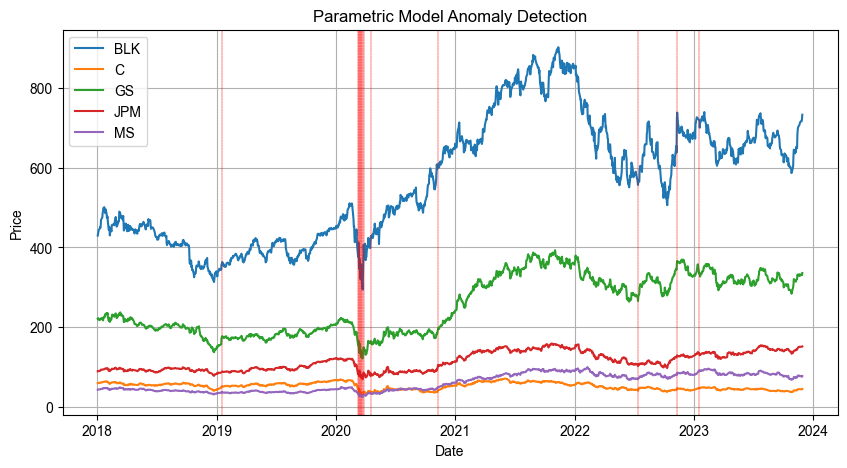

,BLK,C,GS,JPM,MS
Date,,,,,
2019-01-16,357.6,50.9,172.7,87.3,37.4
2020-03-09,376.7,43.5,155.5,81.9,32.7
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-17,347.7,34.1,142.8,82.2,29.4
2020-03-19,357.2,33.6,134.5,74.8,26.9
2020-03-20,318.9,32.2,124.6,73.2,25.8
2020-03-24,334.2,34.4,138.2,77.5,28.9


In [13]:
from scipy.spatial import distance

# Step 1: Calculate the covariance matrix and its inverse
cov_matrix = np.cov(delta, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Step 2: Compute the Mahalanobis distance for each observation
mean_distr = delta.mean(axis=0).values
mahalanobis_distances = delta.apply(lambda row: distance.mahalanobis(row, mean_distr, inv_cov_matrix), axis=1)

delta_maha = delta.copy()

# Add Mahalanobis distances to the DataFrame
delta_maha['Mahalanobis_Dist'] = mahalanobis_distances

# Step 3: Determine anomalies based on a threshold
# Using the 99th percentile of the Mahalanobis distances as the threshold
threshold = mahalanobis_distances.quantile(0.99)
delta_maha['Anomaly'] = delta_maha['Mahalanobis_Dist'] > threshold


parametric_model_result_inx = delta_maha.loc[delta_maha['Anomaly']==True].index

# Plot anomalies detected by parametric model
plot_anomalies(stocks, parametric_model_result_inx, title="Parametric Model Anomaly Detection" , save_loc = 'Figs/parametric model anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(parametric_model_result_inx)].round(1)

### 3.4 Vector Autoregressive (VAR) 


C:\Users\bbanita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


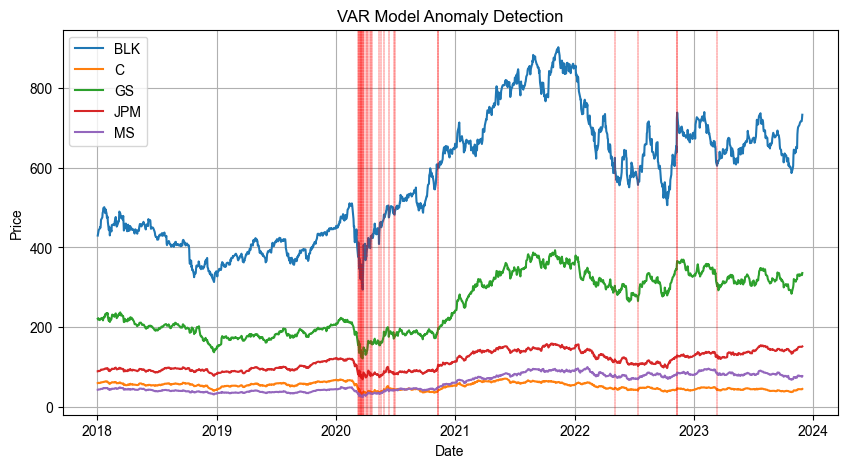

,BLK_value,C_value,GS_value,JPM_value,MS_value,BLK anomaly status,C anomaly status,GS anomaly status,JPM anomaly status,MS anomaly status
Date,,,,,,,,,,
2020-03-10,412.6,47.1,165.9,88.2,34.4,True,True,True,True,True
2020-03-11,387.4,43.0,154.7,84.1,32.1,True,True,True,True,True
2020-03-13,372.0,43.2,159.4,91.1,32.7,True,True,True,True,True
2020-03-16,321.2,34.9,139.2,77.4,27.6,True,True,True,True,True
2020-03-17,347.7,34.1,142.8,82.2,29.4,True,True,True,True,True
2020-03-18,335.6,30.9,126.0,73.5,26.8,True,False,True,True,True
2020-03-19,357.2,33.6,134.5,74.8,26.9,True,True,True,True,True
2020-03-20,318.9,32.2,124.6,73.2,25.8,True,False,True,False,False
2020-03-24,334.2,34.4,138.2,77.5,28.9,True,True,True,True,True


In [14]:
from statsmodels.tsa.api import VAR

# Ensure the data is stationary
data = delta[['BLK', 'C', 'GS', 'JPM', 'MS']].diff().dropna()

# Fit the VAR model
model = VAR(data)
results = model.fit(maxlags=15, ic='aic')

# Forecast the next values
forecast = results.forecast(data.values[-results.k_ar:], steps=len(data))
forecast_df = pd.DataFrame(forecast, index=data.index, columns=data.columns)

# Calculate residuals (forecast errors)
residuals = data - forecast_df

# Calculate the 99th percentile threshold for each column
thresholds = residuals.apply(lambda x: np.percentile(np.abs(x), 99))

# Detect anomalies
anomalies = (np.abs(residuals) > thresholds)

# Add Date index
anomalies.index = delta.index[1:]

# Filter dates with at least 3 True values
anomalies_var_indx = anomalies[anomalies.sum(axis=1) >= 1].index

var_anomaly_value = stocks.loc[stocks.index.isin(anomalies_var_indx)].round(1)
var_anomaly_status = anomalies[anomalies.sum(axis=1) >= 1]

merged_df = pd.merge(var_anomaly_value, var_anomaly_status, left_index=True, right_index=True, how='inner', suffixes=('_value', ' anomaly status'))

var_index = merged_df.index

# Plot anomalies detected by parametric model
plot_anomalies(stocks, var_index, title="VAR Model Anomaly Detection" , save_loc = 'Figs/var model anomalies.jpg')

# Display the numerical values of the anomalies
merged_df

### 3.4 Using Kalman Filter for Anomaly Detection



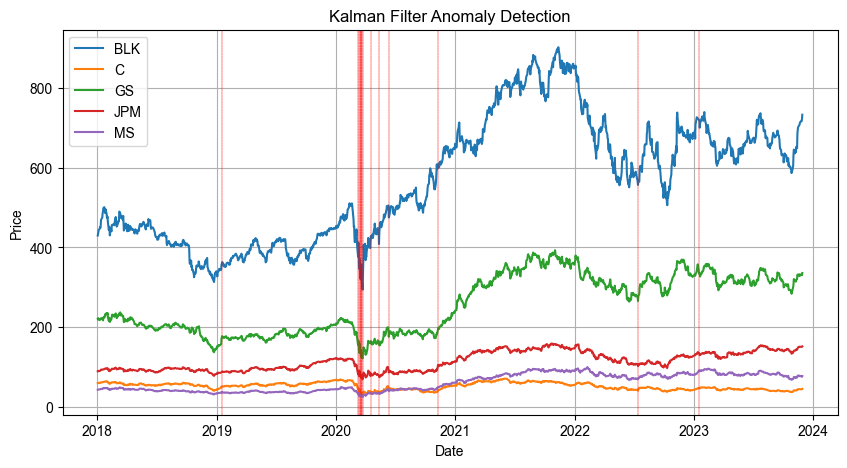

,BLK,C,GS,JPM,MS
Date,,,,,
2019-01-16,357.6,50.9,172.7,87.3,37.4
2020-03-10,412.6,47.1,165.9,88.2,34.4
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-17,347.7,34.1,142.8,82.2,29.4
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-19,357.2,33.6,134.5,74.8,26.9
2020-03-20,318.9,32.2,124.6,73.2,25.8
2020-03-24,334.2,34.4,138.2,77.5,28.9


In [15]:
from filterpy.kalman import KalmanFilter

# Initialize Kalman Filter
kf = KalmanFilter(dim_x=5, dim_z=5)
kf.x = np.zeros(5)  # initial state (location and velocity)
kf.F = np.eye(5)  # state transition matrix
kf.H = np.eye(5)  # observation matrix
kf.P *= 1000.  # covariance matrix
kf.R = np.eye(5)  # measurement noise
kf.Q = np.eye(5)  # process noise

# Apply the Kalman Filter
predictions = []
residuals = []

for i in range(len(delta)):
    z = delta[['BLK', 'C', 'GS', 'JPM', 'MS']].iloc[i].values
    kf.predict()
    kf.update(z)
    predictions.append(kf.x)
    residuals.append(z - kf.x)

predictions = np.array(predictions)
residuals = np.array(residuals)

# Calculate Mahalanobis distance for residuals
mean_residuals = np.mean(residuals, axis=0)
cov_residuals = np.cov(residuals, rowvar=False)
inv_cov_residuals = np.linalg.inv(cov_residuals)

mahalanobis_distances = np.array([
    np.sqrt((res - mean_residuals).T @ inv_cov_residuals @ (res - mean_residuals))
    for res in residuals
])

# Determine anomalies based on 99th percentile
threshold = np.percentile(mahalanobis_distances, 99)
anomalies = mahalanobis_distances > threshold


# Add anomaly column to delta DataFrame

delta_kf = delta.copy()
delta_kf['Mahalanobis_Dist'] = mahalanobis_distances
delta_kf['Anomaly'] = anomalies


kalman_result_indx = delta_kf.loc[delta_kf['Anomaly']==True].index

# Plot anomalies detected by Kalman Filter
plot_anomalies(stocks, kalman_result_indx, title="Kalman Filter Anomaly Detection" , save_loc = 'Figs/kalman filter anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(kalman_result_indx)].round(1)


### 3.5 KNN

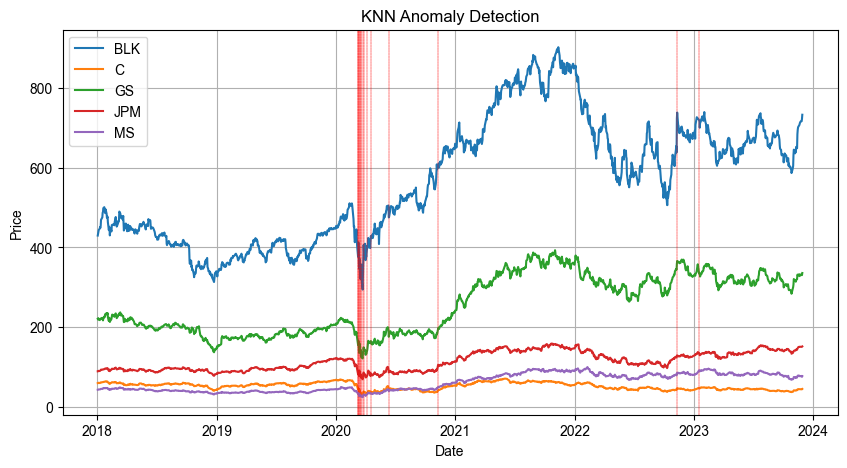

,BLK,C,GS,JPM,MS
Date,,,,,
2020-03-09,376.7,43.5,155.5,81.9,32.7
2020-03-10,412.6,47.1,165.9,88.2,34.4
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-17,347.7,34.1,142.8,82.2,29.4
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-24,334.2,34.4,138.2,77.5,28.9
2020-03-26,406.2,39.0,149.2,86.0,31.1


In [16]:
from sklearn.neighbors import NearestNeighbors

# Define the number of nearest neighbors
knn = 4

# Fit the NearestNeighbors model
nbrs = NearestNeighbors(n_neighbors=knn, metric='euclidean').fit(delta.to_numpy())
distances, indices = nbrs.kneighbors(delta.to_numpy())

# Calculate anomaly scores
anomaly_score = distances[:, knn-1]
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])

# Concatenate the anomaly scores with the original DataFrame
result = pd.concat((delta, anom), axis=1)

# Set the threshold to 99 percent and find the anomalies indexes 
knn_indx = result.nlargest(round(len(delta)*0.01), 'Anomaly score').index


# Plot anomalies detected by KNN model
plot_anomalies(stocks, knn_indx, title="KNN Anomaly Detection" , save_loc = 'Figs/KNN anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(knn_indx)].round(1)


## 3.6 Isolation Forest 



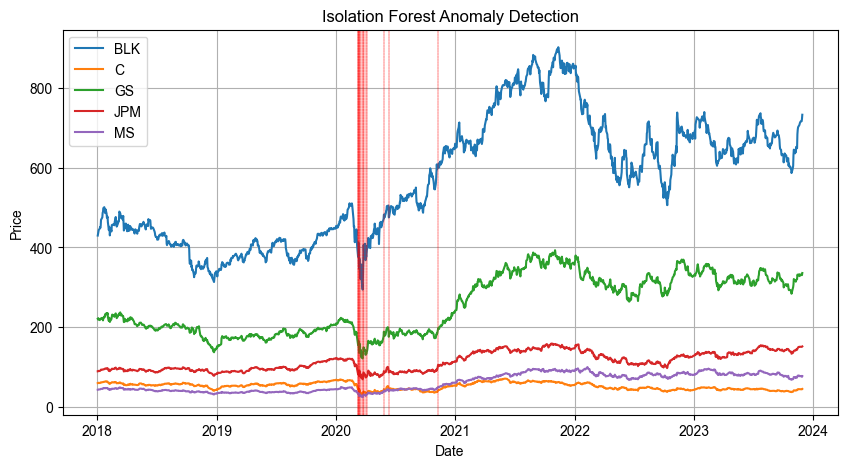

,BLK,C,GS,JPM,MS
Date,,,,,
2020-03-09,376.7,43.5,155.5,81.9,32.7
2020-03-10,412.6,47.1,165.9,88.2,34.4
2020-03-11,387.4,43.0,154.7,84.1,32.1
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-23,294.3,30.0,121.5,69.3,24.2
2020-03-24,334.2,34.4,138.2,77.5,28.9


In [17]:
from sklearn.ensemble import IsolationForest
# Fit the Isolation Forest model
clf = IsolationForest(contamination=0.01, random_state=42)
delta_isolation_forest = delta.copy()
delta_isolation_forest['Anomaly'] = clf.fit_predict(delta[['BLK', 'C', 'GS', 'JPM', 'MS']])

# Convert anomaly labels to Boolean (1 for anomaly, -1 for normal)
delta_isolation_forest['Anomaly'] = delta_isolation_forest['Anomaly'] == -1

if_indx = delta_isolation_forest.loc[delta_isolation_forest['Anomaly']==True].index

# Plot anomalies detected by Isolation Forest model
plot_anomalies(stocks, if_indx, title="Isolation Forest Anomaly Detection" , save_loc = 'Figs/isolation forest anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(if_indx)].round(1)




Epoch 1/50

75/75 [==============================] - 1s 3ms/step - loss: 1.5488 - val_loss: 0.7678
Epoch 2/50
75/75 [==============================] - 0s 2ms/step - loss: 1.2638 - val_loss: 0.6391
Epoch 3/50
75/75 [==============================] - 0s 2ms/step - loss: 1.0422 - val_loss: 0.5479
Epoch 4/50
75/75 [==============================] - 0s 2ms/step - loss: 0.8694 - val_loss: 0.4674
Epoch 5/50
75/75 [==============================] - 0s 1ms/step - loss: 0.7358 - val_loss: 0.4141
Epoch 6/50
75/75 [==============================] - 0s 1ms/step - loss: 0.6429 - val_loss: 0.3744
Epoch 7/50
75/75 [==============================] - 0s 1ms/step - loss: 0.5788 - val_loss: 0.3461
Epoch 8/50
75/75 [==============================] - 0s 1ms/step - loss: 0.5339 - val_loss: 0.3225
Epoch 9/50
75/75 [==============================] - 0s 1ms/step - loss: 0.4997 - val_loss: 0.3046
Epoch 10/50
75/75 [==============================] - 0s 1ms/step - loss: 0.4731 - val_loss: 0.2904
Epoch 11/50
75/

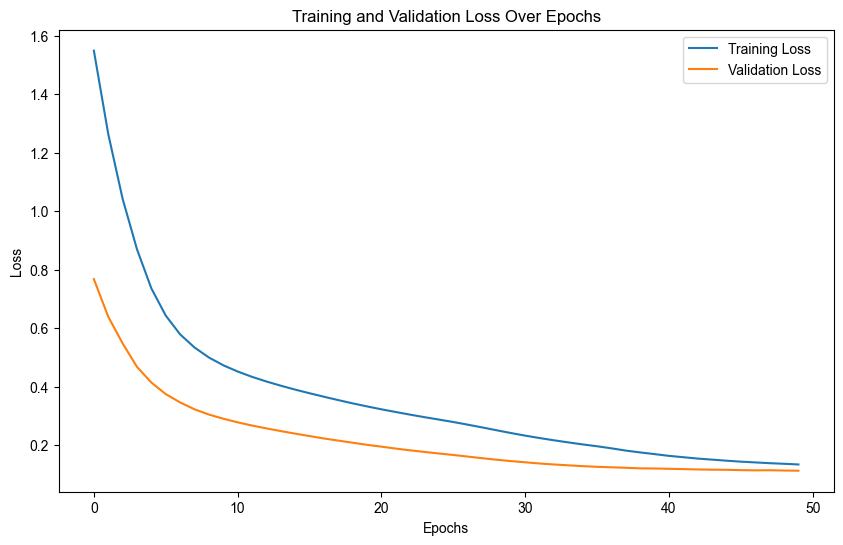

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 3)                 18        
                                                                 
 dense_1 (Dense)             (None, 5)                 20        
                                                                 
Total params: 38 (152.00 Byte)
Trainable params: 38 (152.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


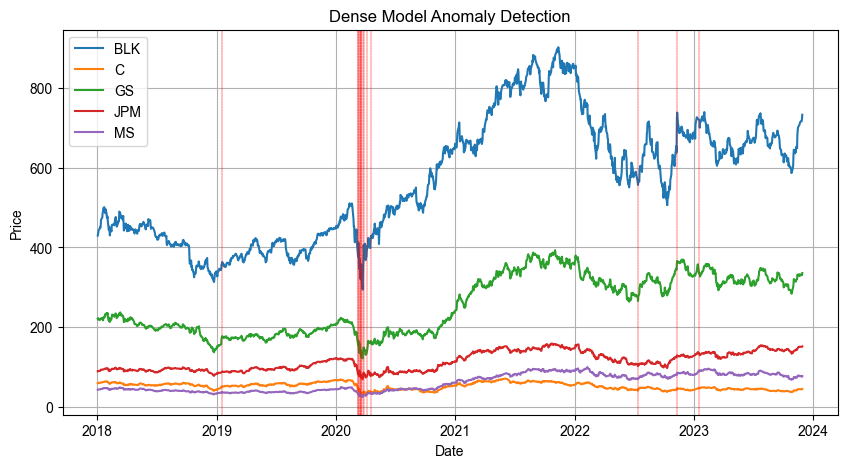

,BLK,C,GS,JPM,MS
Date,,,,,
2019-01-16,357.6,50.9,172.7,87.3,37.4
2020-03-09,376.7,43.5,155.5,81.9,32.7
2020-03-10,412.6,47.1,165.9,88.2,34.4
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-17,347.7,34.1,142.8,82.2,29.4
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-19,357.2,33.6,134.5,74.8,26.9
2020-03-24,334.2,34.4,138.2,77.5,28.9


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

tf.random.set_seed(42)

# Prepare the data
data = delta.values.astype('float32')
input_dim = data.shape[1]

# Define the Autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(3, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the Autoencoder and capture the training history
history = autoencoder.fit(data, data, epochs=50, batch_size=16, shuffle=True, validation_split=0.2)

# Use the trained Autoencoder to reconstruct the input data
reconstructed_data = autoencoder.predict(data)

# Calculate reconstruction errors
mse = np.mean(np.power(data - reconstructed_data, 2), axis=1)

# Set anomaly threshold to 99th percentile
threshold = np.percentile(mse, 99)

# Detect anomalies
anomalies = mse > threshold

# Add anomalies to original DataFrame
delta_autoencoder = delta.copy()
delta_autoencoder['Anomaly'] = anomalies.astype(int)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.savefig('Figs/dense loss epoch.jpg')
plt.show()

autoencoder.summary()
# Print anomalies


dense_indx = delta_autoencoder[delta_autoencoder['Anomaly'] == 1].index

# Plot anomalies detected by Dense model
plot_anomalies(stocks, dense_indx, title="Dense Model Anomaly Detection" , save_loc = 'Figs/Dense anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(dense_indx)].round(1)



Epoch 1/50
75/75 [==============================] - 2s 7ms/step - loss: 1.0821 - val_loss: 0.6152
Epoch 2/50
75/75 [==============================] - 0s 2ms/step - loss: 0.9933 - val_loss: 0.5404
Epoch 3/50
75/75 [==============================] - 0s 2ms/step - loss: 0.7096 - val_loss: 0.3650
Epoch 4/50
75/75 [==============================] - 0s 2ms/step - loss: 0.4293 - val_loss: 0.2570
Epoch 5/50
75/75 [==============================] - 0s 2ms/step - loss: 0.2901 - val_loss: 0.2084
Epoch 6/50
75/75 [==============================] - 0s 2ms/step - loss: 0.2242 - val_loss: 0.1845
Epoch 7/50
75/75 [==============================] - 0s 2ms/step - loss: 0.2027 - val_loss: 0.1784
Epoch 8/50
75/75 [==============================] - 0s 2ms/step - loss: 0.1912 - val_loss: 0.1678
Epoch 9/50
75/75 [==============================] - 0s 2ms/step - loss: 0.1840 - val_loss: 0.1665
Epoch 10/50
75/75 [==============================] - 0s 2ms/step - loss: 0.1782 - val_loss: 0.1637
Epoch 11/50
75/75 [

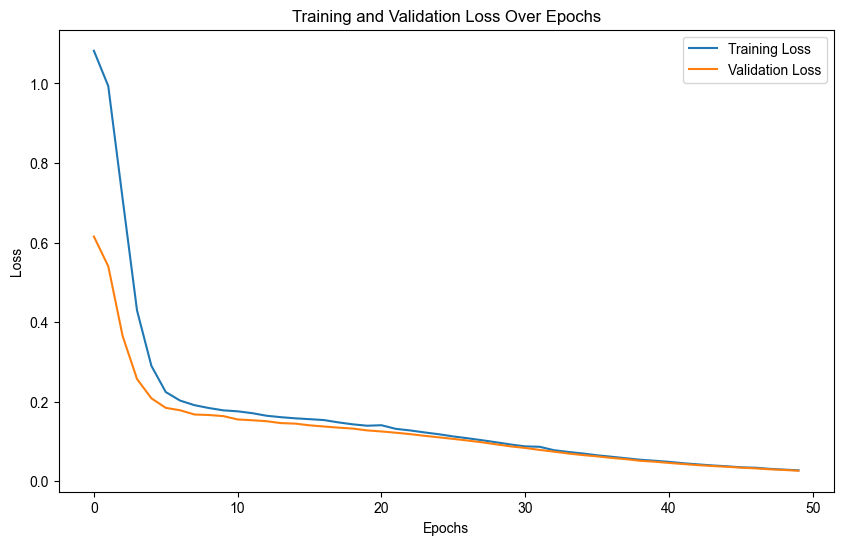

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 5)]            0         
                                                                 
 lstm (LSTM)                 (None, 10)                640       
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 10)             0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1, 5)              320       
                                                                 
Total params: 960 (3.75 KB)
Trainable params: 960 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


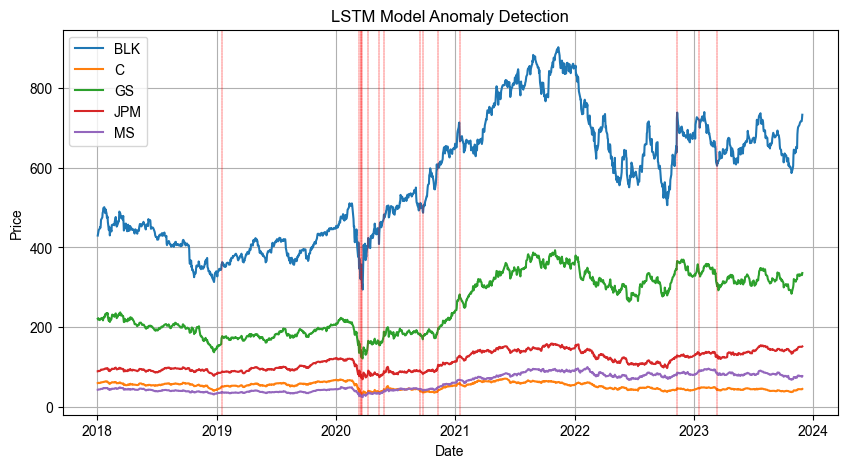

,BLK,C,GS,JPM,MS
Date,,,,,
2019-01-16,357.6,50.9,172.7,87.3,37.4
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-17,347.7,34.1,142.8,82.2,29.4
2020-03-19,357.2,33.6,134.5,74.8,26.9
2020-03-20,318.9,32.2,124.6,73.2,25.8
2020-04-07,398.4,34.9,149.4,80.3,32.2
2020-05-13,436.7,34.8,154.6,74.4,32.5
2020-05-28,482.6,42.1,181.1,88.4,39.0
2020-09-14,498.3,41.6,183.4,91.6,45.3


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector


# Prepare the data
data = delta.values.astype('float32')

# Reshape data to 3D for LSTM input: (samples, timesteps, features)
timesteps = 1 
data = data.reshape((data.shape[0], timesteps, data.shape[1]))

# Define the Autoencoder architecture
input_layer = Input(shape=(timesteps, data.shape[2]))
encoded = LSTM(10, activation='relu', return_sequences=False)(input_layer)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(data.shape[2], activation='linear', return_sequences=True)(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the Autoencoder and capture the training history
history = autoencoder.fit(data, data, epochs=50, batch_size=16, shuffle=True, validation_split=0.2)

# Use the trained Autoencoder to reconstruct the input data
reconstructed_data = autoencoder.predict(data)

# Reshape reconstructed data back to 2D for error calculation
reconstructed_data = reconstructed_data.reshape((reconstructed_data.shape[0], reconstructed_data.shape[2]))
data_2d = data.reshape((data.shape[0], data.shape[2]))

# Calculate reconstruction errors
mse = np.mean(np.power(data_2d - reconstructed_data, 2), axis=1)

# Set anomaly threshold to 99th percentile
threshold = np.percentile(mse, 99)

# Detect anomalies
anomalies = mse > threshold

# Add anomalies to original DataFrame
delta_autoencoder = delta.copy()
delta_autoencoder['Anomaly'] = anomalies.astype(int)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.savefig('Figs/lstm_loss_epoch.jpg')
plt.show()

autoencoder.summary()
# Print anomalies

lstm_indx = delta_autoencoder[delta_autoencoder['Anomaly'] == 1].index

# Plot anomalies detected by LSTM model
plot_anomalies(stocks, lstm_indx, title="LSTM Model Anomaly Detection" , save_loc = 'Figs/lstm anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(lstm_indx)].round(1)


Epoch 1/50
38/38 [==============================] - 2s 11ms/step - loss: 0.9600 - val_loss: 0.4576
Epoch 2/50
38/38 [==============================] - 0s 5ms/step - loss: 0.6485 - val_loss: 0.2360
Epoch 3/50
38/38 [==============================] - 0s 3ms/step - loss: 0.3134 - val_loss: 0.2310
Epoch 4/50
38/38 [==============================] - 0s 3ms/step - loss: 0.2593 - val_loss: 0.1807
Epoch 5/50
38/38 [==============================] - 0s 3ms/step - loss: 0.2167 - val_loss: 0.1500
Epoch 6/50
38/38 [==============================] - 0s 3ms/step - loss: 0.1643 - val_loss: 0.1178
Epoch 7/50
38/38 [==============================] - 0s 3ms/step - loss: 0.1220 - val_loss: 0.0906
Epoch 8/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0869 - val_loss: 0.0678
Epoch 9/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0597 - val_loss: 0.0485
Epoch 10/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0406 - val_loss: 0.0364
Epoch 11/50
38/38 

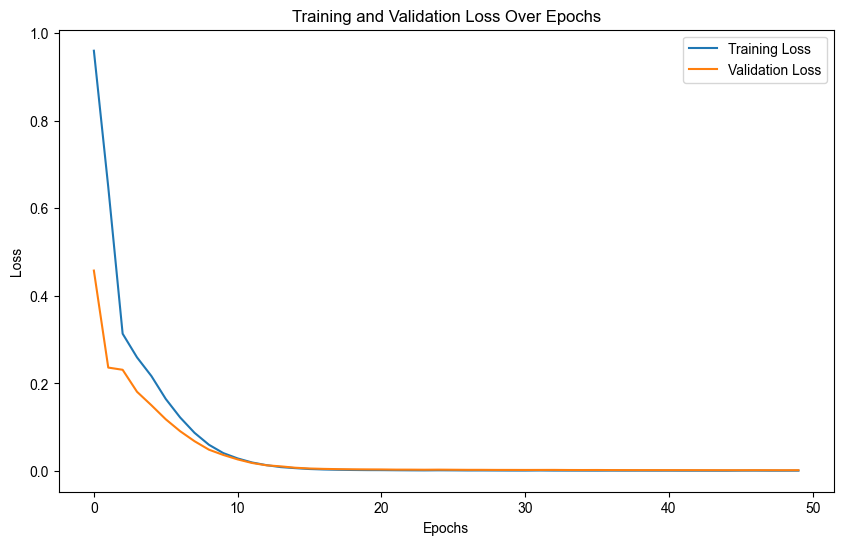

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 5)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               68608     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 1, 128)            0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 1, 128)            131584    
                                                                 
 time_distributed (TimeDist  (None, 1, 5)              645       
 ributed)                                                        
                                                                 
Total params: 200837 (784.52 KB)
Trainable params: 200837 (

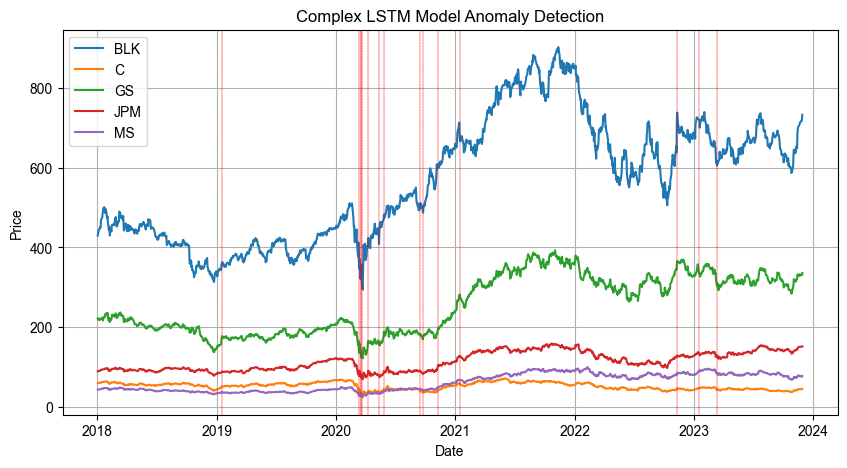

,BLK,C,GS,JPM,MS
Date,,,,,
2019-01-16,357.6,50.9,172.7,87.3,37.4
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-17,347.7,34.1,142.8,82.2,29.4
2020-03-19,357.2,33.6,134.5,74.8,26.9
2020-03-20,318.9,32.2,124.6,73.2,25.8
2020-04-07,398.4,34.9,149.4,80.3,32.2
2020-05-13,436.7,34.8,154.6,74.4,32.5
2020-05-28,482.6,42.1,181.1,88.4,39.0
2020-09-14,498.3,41.6,183.4,91.6,45.3


In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, RepeatVector, TimeDistributed, Dense

# Assuming delta is your DataFrame
# Prepare the data
data = delta.values.astype('float32')

# Number of timesteps to look back
timesteps = 1  

# Ensure the number of data points is divisible by the number of timesteps
num_samples = (data.shape[0] // timesteps) * timesteps
data = data[:num_samples]

# Reshape data to 3D for LSTM input: (samples, timesteps, features)
data = data.reshape((data.shape[0] // timesteps, timesteps, data.shape[1]))

# Define the Autoencoder architecture
input_layer = Input(shape=(timesteps, data.shape[2]))
encoded = LSTM(128, activation='relu', return_sequences=False)(input_layer)
#encoded = Dropout(0.1)(encoded)
encoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(128, activation='relu', return_sequences=True)(encoded)
#decoded = Dropout(0.1)(decoded)
decoded = TimeDistributed(Dense(data.shape[2]))(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the Autoencoder and capture the training history
history = autoencoder.fit(data, data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Use the trained Autoencoder to reconstruct the input data
reconstructed_data = autoencoder.predict(data)

# Reshape reconstructed data back to 2D for error calculation
reconstructed_data = reconstructed_data.reshape((reconstructed_data.shape[0] * timesteps, reconstructed_data.shape[2]))
data_2d = data.reshape((data.shape[0] * timesteps, data.shape[2]))

# Calculate reconstruction errors
mse = np.mean(np.power(data_2d - reconstructed_data, 2), axis=1)

# Set anomaly threshold to 99th percentile
threshold = np.percentile(mse, 99)

# Detect anomalies
anomalies = mse > threshold

# Add anomalies to original DataFrame
delta_lstm = delta.iloc[:num_samples].copy()
delta_lstm['Anomaly'] = anomalies.astype(int)


# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.savefig('Figs/lstm_comlex_loss_epoch.jpg')
plt.show()

autoencoder.summary()
# Print anomalies

lstm_complex_indx = delta_autoencoder[delta_autoencoder['Anomaly'] == 1].index

# Plot anomalies detected by LSTM model
plot_anomalies(stocks, lstm_complex_indx, title="Complex LSTM Model Anomaly Detection" , save_loc = 'Figs/lstm complex anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(lstm_complex_indx)].round(1)